<center> <h1> Stock Return Analysis and the Efficient Frontier </h1> </center>
<center> <h3> Group 12: Congci Hao</h3> </center>

<b> Project Scope: </b>

The goal of this notebook is to anlayze stock performance of 30 stocks in the Dow Jones list over the past 10 years from 1/1/2010 to 1/1/2019 by comparing expected returns and realized returns through the application of Captial Asset Pricing Model (CAPM). Later, I selected three top performers based on alpha, the ability to beat the market, and visualized the portfolio optimization by constructing the efficient frontier. In the end, I conducted regression analysis to explore pontential relationships between minimum variance portfolio and other variables. 
 

<b> Sections: </b>

<ul> I. Analyze the expected returns of 30 stocks in the Dow Jones list by applying CAPM </ul>
<ul> II. Measure stock performance by calculating important statistics and comparing the expected returns and realized returns</ul>
<ul> III. Interpret and visualize stock returns by companies and industries to conclude investment insights </ul>
<ul> IV. Construct the efficient frontier of the portfolio composed of top 3 performers based on alphas </ul>
<ul> V. Perform regression analysis on the minimum variance portfolio against the S&P 500 index and Google Trends</ul>
<ul> VI. Conclusion </ul>

## Section I: Analyze the Expected Return 
### Retrieve company information of 30 companies in the Dow Jones list

I extracted basic company information from the wikipedia page (https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average) by using BeautifulSoup and built a list company tickers that will be used later to retreive stock prices. Company information includes company name, stock tickers, and industry, which are transformed to a pandas dataframe.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pandas_datareader import data as wb

from scipy import stats
import statsmodels.api as sm 

from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Set the maximum number of outputs 
pd.options.display.max_rows = 20

In [3]:
import re, requests
from bs4 import BeautifulSoup

url = 'https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average'
req = requests.get(url)
html = req.text

#content = re.findall('<tbody>.+?</tbody>',html,re.DOTALL)
soup = BeautifulSoup(html, 'html.parser')

records = []
tt = ()
table = soup.find('table', attrs={'class':"wikitable sortable"})
entries = table.find_all('tr')
for entry in entries:

    columns = entry.find_all('td')
    
    if len (columns)>5 :

        name = columns[0].get_text().strip('\n')
        ticker = columns[2].get_text().strip('\n')
        industry = columns[3].get_text().strip('\n')

        tt = (name,ticker,industry)

    records.append(tt)
#Need to filter an empty list from the source code
records = list(filter(None, records))

print(records)
len(records)

[('3M', 'MMM', 'Conglomerate'), ('American Express', 'AXP', 'Financial services'), ('Apple', 'AAPL', 'Information technologies'), ('Boeing', 'BA', 'Aerospace and defense'), ('Caterpillar', 'CAT', 'Construction and mining equipment'), ('Chevron', 'CVX', 'Oil & gas'), ('Cisco Systems', 'CSCO', 'Information technologies'), ('Coca-Cola', 'KO', 'Food'), ('Dow Inc.', 'DOW', 'Chemical industry'), ('ExxonMobil', 'XOM', 'Oil & gas'), ('Goldman Sachs', 'GS', 'Financial services'), ('The Home Depot', 'HD', 'Retail'), ('IBM', 'IBM', 'Information technologies'), ('Intel', 'INTC', 'Information technologies'), ('Johnson & Johnson', 'JNJ', 'Pharmaceuticals'), ('JPMorgan Chase', 'JPM', 'Financial services'), ("McDonald's", 'MCD', 'Food'), ('Merck & Company', 'MRK', 'Pharmaceuticals'), ('Microsoft', 'MSFT', 'Information technologies'), ('Nike', 'NKE', 'Apparel'), ('Pfizer', 'PFE', 'Pharmaceuticals'), ('Procter & Gamble', 'PG', 'Consumer goods'), ('Travelers', 'TRV', 'Insurance'), ('UnitedHealth Group', 

30

In [4]:
# Transform the list of tuples in the varaible records into a pandas dataframe 
df = pd.DataFrame(records)

# Set column names 
df.columns=['Company','Ticker','Industry']

### Construct the dataframe of stock prices for 30 companies and calculate the stock returns 

I retreived the daily stock prices of 30 stocks based on the tickers from previous section by using the pandas datareader through Yahoo Finance API. The daily stock prices are used to calculate the stock returns in the logarithm term because it reduces the variation of the time series.

Two new dataframes:

<b> log_returns: </b> includes S&P 500 ('^GSPC')

<b> sec_returns: </b> without S&P 500

In [5]:
tickers = list(df['Ticker'])
tickers.append('^GSPC')

end = datetime.today()
start = datetime(end.year-5,end.month,end.day)

sec_data = pd.DataFrame()
for t in tickers:
    sec_data[t] = wb.DataReader(t,data_source='yahoo',start=start,end=end)['Adj Close']

sec_data.tail()

,MMM,AXP,AAPL,BA,CAT,CVX,CSCO,KO,DOW,XOM,...,PG,TRV,UNH,UTX,VZ,V,WMT,WBA,DIS,^GSPC
Date,,,,,,,,,,,,,,,,,,,,,
2019-04-16,216.899994,111.879997,199.250000,381.720001,141.174271,121.169998,56.950001,46.950001,58.500000,81.199997,...,105.673996,138.339996,220.960007,135.339996,58.790001,160.229996,102.930000,54.840000,129.899994,2907.060059
2019-04-17,217.639999,111.760002,203.130005,377.519989,141.880005,120.269997,56.310001,47.279999,58.320000,81.430000,...,105.849998,135.869995,216.839996,135.789993,57.779999,160.440002,103.160004,55.139999,131.750000,2900.449951
2019-04-18,218.880005,113.669998,203.860001,380.070007,143.360001,119.860001,56.400002,47.480000,57.770000,81.129997,...,106.050003,138.929993,221.750000,137.000000,58.040001,160.160004,103.180000,54.630001,132.449997,2905.030029
2019-04-22,218.539993,112.330002,204.529999,375.170013,142.380005,121.900002,56.340000,47.400002,57.889999,82.900002,...,106.010002,136.610001,227.110001,136.910004,58.369999,160.399994,102.370003,54.099998,131.679993,2907.969971
2019-04-23,219.500000,113.970001,207.479996,374.019989,142.029999,122.019997,56.689999,48.209999,57.639999,83.379997,...,103.160004,138.009995,230.580002,140.020004,57.150002,161.660004,103.070000,53.220001,133.360001,2933.679932


In [6]:
#Substitute the missing values with the average of that company's stock prices
sec_data = sec_data.apply(lambda x: x.fillna(x.mean()),axis=0)

In [7]:
# pct_change(obtains simple returns from a given dataset
log_returns = np.log(1 + sec_data.pct_change())

In [8]:
#Construct the stock returns without SP500 
sec_returns = log_returns.iloc[:,:-1]

### Calculate realized returns, variance, volatility, and betas and build new columns into the 'df' dataframe

I calculated annual realized returns by multiplying approximate 250 trading days. Similar methods for the volatility. Then I calculated the stock betas by calculating the stock variance and its covariance with S&P 500. 

With pre-specified risk-free rates based on the yields of U.S T-Bills, I came up with the market preimum by subracting the risk free rate from the market return of S&P 500. In the end, I calculated the expected returns of each stock in the Dow Jones list by applying CAPM.

In [9]:
# Calculate the annual return based on the mean and 250 trading days each year
# Add to the master data frame
df['Realized_Return'] = list(sec_returns.mean()*250)

In [10]:
# Calculate the volatility which is the standard deviation 
# Add to the master data frame
df['Volatility'] = list(sec_returns.std()*250**0.5)

In [11]:
# Compute the variance and compare the covariance with SP500
cov = log_returns.cov()*250

In [12]:
# Compute the corrleation and compare with SP500
corr = log_returns.corr()

<b> Beta Formula: </b>
### $$ 
\beta_{pg} = \frac{\sigma_{pg,m}}{\sigma_{m}^2}
$$

In [13]:
# Calculate stock betas basd on the formula above

betas=[]
for num in range(30):
    cov_with_market = cov.iloc[30,num]
    market_var = log_returns['^GSPC'].var()*250
    beta = cov_with_market / market_var
    betas.append(beta)

In [14]:
df['Beta']=betas

In [15]:
# Set the Ticker as the index
df = df.set_index('Ticker')

**Calculate the expected return (CAPM):**
### $$
\overline{r_{s}} = r_f + \beta_{s}(\overline{r_{m}} - r_f) 
$$

In [16]:
# I assume that the risk-free rate is 2.5% from government-issued T-bills
rf = 0.025
# Calculate the Market Preimum by subtracing the risk-free rate from the market return 
rp = log_returns['^GSPC'].mean()*250 - rf

In [17]:
# Calculate the Exptected Return by applying the CAPM forumla above
df['Expected_Return'] = df['Beta']*rf +rf

## Section II: Measure stock performance by calculating important statistics and comparing the expected returns and realized returns

I appended the volatility, realized returns to the original dataframe and and calculated Alpha as the difference between the expected returns and the realized returns.  

In [18]:
df.describe()

,Realized_Return,Volatility,Beta,Expected_Return
count,30.000000,30.000000,30.000000,30.000000
mean,0.116916,0.196580,0.913524,0.047838
std,0.082301,0.040464,0.284955,0.007124
min,-0.027148,0.067406,0.011080,0.025277
25%,0.066449,0.175056,0.785652,0.044641
50%,0.094972,0.197953,0.948758,0.048719
75%,0.187155,0.227220,1.148842,0.053721
max,0.251930,0.261497,1.329429,0.058236


In [19]:
df = df.sort_values('Expected_Return',ascending=False)

***Alpha*** describe an investment strategy to beat the market or its edge, also known as "excess return" or "abnormal rate of return", which refers to the idea that markets are efficient and there is no way to systemtially earn returns.

Alpha is often used to rank actual mutual funds as well as other types of investments.

In [20]:
#Calculate Alpaha which is the difference between the exptected reutrn and realized returns
df['Alpha'] = df['Realized_Return']-df['Expected_Return']

In [21]:
df['Min_Return'] = log_returns.min()
df['Max_Return'] = log_returns.max()

In [22]:
# Dispaly Betas and Volatility as 2 decimals digits 
# Transform Realized Return and Expected Returns to 2 decimals percentages

df.style.format({
    'Beta': '{:,.2f}'.format,
    'Volatility': '{:,.2f}'.format,
    'Realized_Return': '{:,.2%}'.format,
    'Expected_Return': '{:,.2%}'.format,
    'Expected_Return': '{:,.2%}'.format,
    'Alpha': '{:,.2%}'.format,
    'Min_Return': '{:,.2%}'.format,
    'Max_Return': '{:,.2%}'.format,
})

,Company,Industry,Realized_Return,Volatility,Beta,Expected_Return,Alpha,Min_Return,Max_Return
Ticker,,,,,,,,,
CAT,Caterpillar,Construction and mining equipment,9.66%,0.26,1.33,5.82%,3.83%,-9.57%,7.57%
MSFT,Microsoft,Information technologies,25.19%,0.23,1.29,5.71%,19.48%,-9.71%,9.94%
GS,Goldman Sachs,Financial services,6.15%,0.23,1.27,5.67%,0.48%,-7.75%,9.12%
INTC,Intel,Information technologies,18.48%,0.25,1.22,5.56%,12.93%,-9.54%,10.03%
AAPL,Apple,Information technologies,22.67%,0.24,1.19,5.48%,17.20%,-10.49%,7.88%
JPM,JPMorgan Chase,Financial services,16.77%,0.21,1.18,5.45%,11.32%,-7.20%,8.00%
V,Visa,Financial services,23.66%,0.21,1.16,5.39%,18.27%,-5.41%,9.75%
BA,Boeing,Aerospace and defense,23.60%,0.24,1.15,5.38%,18.21%,-9.35%,9.42%
CSCO,Cisco Systems,Information technologies,20.65%,0.21,1.14,5.34%,15.31%,-7.49%,9.20%


In [23]:
#Calculate the mean of S&P 500 return over the past 10 years
log_returns['^GSPC'].mean()*250

0.08891910547406275

### Insights:
Capital Asset Pricing Model serves as a benchmark for any asset we would need to have a vew of the "fair" return given the asset's risk

1. Comparing the expected return with the realized return, it does not reflect the whole story behind the relationship between risk and returns. CAPM only takes into account the asset's sensitivity to market risk (systemetic risk). 
2. The difference between an asset's actual returns and expected returns is alpha, which gauges the performance of an investment against a market index or benchmark. In this case, Boeing outperforms the market most. 

## Section III: Interpret and Visualize Stock Returns by Companies and Industries to Conclude Investment Insights
### Data Visualizations of 30 Companies in Dow Jones List 

I used the 'plotly' package to visualize the important measures of stock returns of 30 companies based on realized returns, expected returns, alpha, and industries.

In [24]:
from plotly.graph_objs import Scatter, Layout
import plotly
import plotly.offline as py
import plotly.graph_objs as go

# setting offline
plotly.offline.init_notebook_mode(connected=True)

In [25]:
# Compare the Expected Return and Realized Return

trace0 = go.Bar(
    x = df.index,
    y = df['Realized_Return'],
    name = 'Realized Return',
    text = df['Company'],
    marker = dict(
        color='rgb(49,130,189)',
    )
)

trace1 = go.Bar(
    x = df.index,
    y = df['Expected_Return'],
    name = 'Expected Return',
    marker = dict(
        color='rgb(204,204,204)',
    )
)



layout = go.Layout(
    title=go.layout.Title(
        text='Realized Returns vs. Expected Returns',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        tickangle=45,
        title=go.layout.xaxis.Title(
            text='Company Tickers',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        tickformat = '%',
        title=go.layout.yaxis.Title(
            text='Stock Returns',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    shapes=[
            {
                'type': 'line',
                'xref': 'paper',
                'x0': 0,
                'y0': 0.0797, # use absolute value or variable here
                'x1': 1,
                'y1': 0.0797, # ditto
                'line': {
                    'color': 'red',
                    'width': 1,
                    'dash': 'solid',
                },
            },
        ],
    
)

data = [trace0,trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [26]:

df = df.sort_values('Alpha',ascending = False)

trace0 = go.Bar(
    x = df.index,
    y = df['Alpha'],
    name = 'Alpha',
    text = df['Company'],
    marker = dict(
        color='rgb(49,130,189)',
    )
)

layout = go.Layout(
    title=go.layout.Title(
        text='Comparison on Alpha (Difference in Returns) Across 30 Dow Jones Stocks',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        tickangle=45,
        title=go.layout.xaxis.Title(
            text='Company Tickers',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        tickformat = '%',
        title=go.layout.yaxis.Title(
            text='$\Delta$',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)

data = [trace0]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [27]:
# Calculate and compare the average realized returns in each industry
df_industry = df.groupby('Industry', as_index=False)['Realized_Return'].mean()
df_industry = df_industry.sort_values('Realized_Return',ascending = False)

trace0 = go.Bar(
    x = df_industry['Industry'],
    y = df_industry['Realized_Return'],
    name = 'Realized Return',
    text = 'Stock Returns',
    marker = dict(
        color='rgb(49,130,189)',
    )
)

layout = go.Layout(
     autosize=False,
     width = 800,
     height = 1000,
     margin=go.layout.Margin(
        l=50,
        r=50,
        b=300,
        t=100,
        pad=4
    ),
    title=go.layout.Title(
        text='Realized Returns by Industry',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        tickangle=30,
        title=go.layout.xaxis.Title(
            text='Industry',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        tickformat = '%',
        title=go.layout.yaxis.Title(
            text='Stock Returns',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    )
)

data = [trace0]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Section IV: Construct and Visualize the Efficient Frontier of the Portfolio Composed of Top 3 Performers

1. Select the top three performers from the 30 companies based on alphas (Shown in the previous graph "Comparsion on Alphas")
2. Assign random weights to each stock in the portfolio
3. Generate 1000 random portfoilos and construct a new data frame 
4. Calculate the expected portfolio return and portfolio volatilities
5. Plot the 1000 outcomes from the Monte Carlo simulation

In [28]:
# Select Top Three Performers
top_performers = ['BA','MSFT','UNH']
top_returns = sec_returns[top_performers]

In [29]:
#Set the figure sizes
plt.rcParams['figure.figsize'] = (10,8)

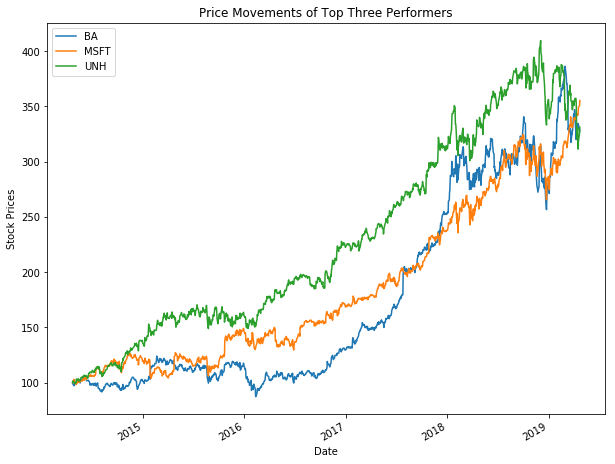

In [30]:
# Plot stock price movements over the past 10 years
(sec_data[top_performers]/sec_data[top_performers].iloc[0]*100).plot();
plt.ylabel('Stock Prices');
plt.title('Price Movements of Top Three Performers');

In [31]:
# Set the number of assets to assign weights
num_assets = 3

# Set the number of runs of random portfolio weights
num_portfolios = 1000

# Set up array to hold results
results = np.zeros((num_assets,num_portfolios))
results

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [32]:
#Generate the random weights for each company 
weights = np.random.random(num_assets)
weights /= np.sum(weights)
weights,sum(weights)

(array([0.46278909, 0.32989746, 0.20731344]), 1.0)

In [33]:
# Test the calculation of portfolio returns with random weights 
top_returns.mean()*250*weights

BA      0.109200
MSFT    0.083111
UNH     0.049318
dtype: float64

In [34]:
# Expected Portfolio Return
np.sum(weights*top_returns.mean()*250)

0.24162800200238435

In [35]:
# Expected Portfolio Volatility
np.sqrt(np.dot(weights.T,np.dot(top_returns.cov()*250, weights)))

0.18225519891074712

## Construct the Efficient Frontier by Running Monte Carlo Simulations

In [36]:
import copy

pfolio_returns = []
pfolio_volatilities = []

min = float("inf")
min_weights = []

for x in range (num_portfolios):
    
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    pfolio_returns = np.sum(weights * top_returns.mean()) * 250
    pfolio_volatilities = np.sqrt(np.dot(weights.T,np.dot(top_returns.cov() * 250, weights)))
    
    if pfolio_volatilities < min:
        min_weights = copy.deepcopy(weights)
        
    # Store results in results array
    results[0,x] = pfolio_returns
    results[1,x] = pfolio_volatilities
    # Store Sharpe Ratio(return/volatility) - risk free rate 
    results[2,x] = (results[0,x]- rf)/results[1,x]
    
print (min_weights)    
# convert results array to Pandas DataFrame
results_frame = pd.DataFrame(results.T,columns =['Return','Volatility','Sharpe'])

#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['Sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['Volatility'].idxmin()]

[0.15351584 0.27595592 0.57052825]


In [37]:
results_frame.Return.max()

0.2507581598984722

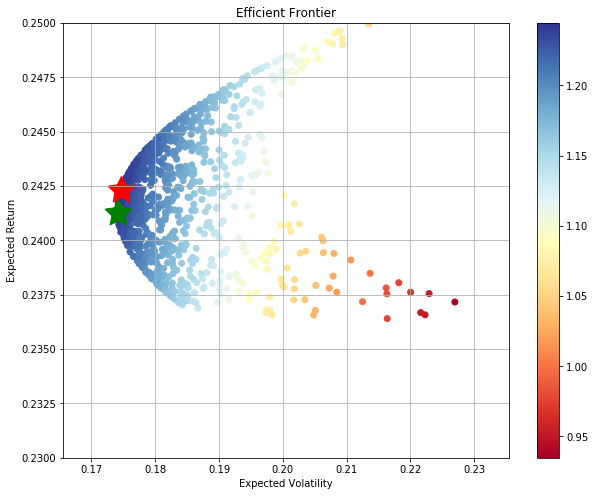

In [38]:
# # Visualize the effecient frontier from 1000 times simulations 
plt.scatter(results_frame.Volatility,results_frame.Return,c=results_frame.Sharpe,cmap='RdYlBu')
plt.colorbar()
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier')
plt.ylim((0.23,0.25)) 
plt.grid(True)

#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=800)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=800)

plt.show()

### Insights: 
Economist Markowitz proved the existence of an efficient set of portfolios that optimize investors' return for the amount of risk they are willing to accept. 

Here, I constructed the efficient frontier by building a promising set of portfolios of three stocks with highest alphas. I labeled the minimum variance portfolio with a green star that is a perfect investment choice for investors who want to optimize the portfolio return without assuming additional risk. 

Sharpe ratio is a measure of risk-adjusted returns. The portfolio with the highest Sharpe Ratio labeled as a redstart is intended for investors who want to pursue the highest return for a given amount of risk. As you have seen from the graph, if the risk-free rate is the intercept on the y-axis and you plot the tangency line of the efficient frontier, the red portfolio is where the tangent line and the efficient frontier intersect. 

Sharpe Ratio = (Expected Returns - Risk-Free Rate)/Expected Volatilities

## Section V: Perform Regression Analysis on the Minimum Variance Portfolio Against the S&P 500 Index and Google Trends
### Visualize the stock returns fluctuations of the minimum variance portfolio

In [39]:
min_port_returns = np.sum(min_weights * top_returns)
market_data = wb.DataReader(['^DJI','^GSPC'],data_source='yahoo',start=start,end=end)['Adj Close']

In [40]:
top_returns = min_weights*top_returns
top_returns['Total']=top_returns['BA'] + top_returns['MSFT'] + top_returns['UNH']

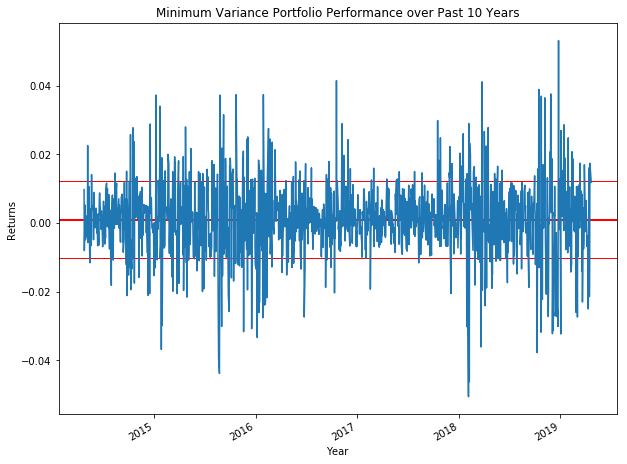

In [41]:
#Plot the portfolio performance over the past 10 years

graph = top_returns['Total'].plot();
plt.ylabel('Returns');
plt.xlabel('Year')
plt.title('Minimum Variance Portfolio Performance over Past 10 Years');

graph.axhline(y=top_returns['Total'].mean(),c="red",linewidth=2,zorder=0);
graph.axhline(y=top_returns['Total'].mean()+top_returns['Total'].std(),c="red",linewidth=1,zorder=0);
graph.axhline(y=top_returns['Total'].mean()-top_returns['Total'].std(),c="red",linewidth=1,zorder=0);

### Regress on the portfolio returns against the S&P 500 market returns

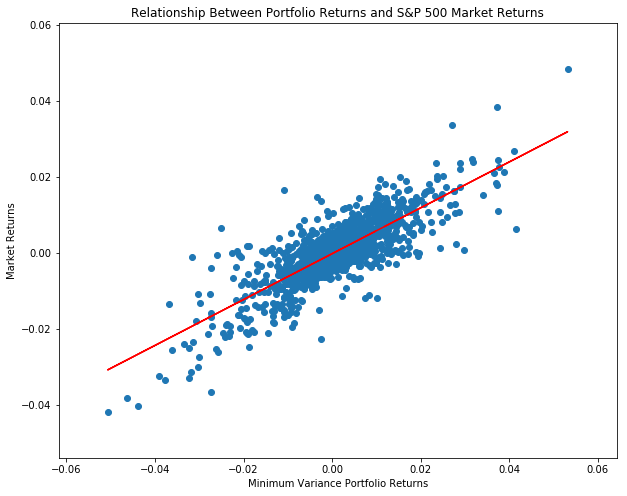

In [42]:
#Draw the scatter plot with minimum variance portfolio returns as an independent variable and SP500 market index as a dependent variable

X1 = top_returns['Total'][1:]
Y1 = log_returns['^GSPC'][1:]
plt.scatter(X1,Y1);
plt.xlabel('Minimum Variance Portfolio Returns')
plt.ylabel('Market Returns')
plt.title('Relationship Between Portfolio Returns and S&P 500 Market Returns')

#Draw the trend line
z = np.polyfit(X1,Y1,1)
p = np.poly1d(z)
plt.plot(X1,p(X1),"r")
plt.show();

In [43]:
#Apply statsmodel to run regression and conclude detailed stats
x_hat = sm.add_constant(X1)
reg = sm.OLS(Y1, x_hat).fit()

In [44]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ^GSPC   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     2367.
Date:                Tue, 23 Apr 2019   Prob (F-statistic):          3.55e-291
Time:                        21:00:55   Log-Likelihood:                 4901.1
No. Observations:                1258   AIC:                            -9798.
Df Residuals:                    1256   BIC:                            -9788.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.000     -1.631      0.103      -0.001     4.6e-05
Total          0.6035      0.012     48.647      0.000       0.579       0.628
==============================================================================
Omnibus:                       60.578   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.155
Skew:                           0.007   Prob(JB):                     7.68e-45
Kurtosis:                       4.969   Cond. No.                         89.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
comparison = {'Minimum Portfoilo Returns':[top_returns['Total'].mean()*250], 'S&P 500 Returns':[log_returns['^GSPC'].mean()*250]}
comparison = pd.DataFrame(comparison)
comparison.style.format({
    'Minimum Portfoilo Returns': '{:,.2%}'.format,
    'S&P 500 Returns': '{:,.2%}'.format,
})

,Minimum Portfoilo Returns,S&P 500 Returns
0,24.15%,8.89%


### Regress on the portfolio returns against the Google Searches of relevant keywords

In [46]:
from pytrends.request import TrendReq
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = ['Boeing','Software','Healthcare']

In [47]:
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')

kw_searches = pytrends.interest_over_time()
kw_searches = kw_searches.iloc[1:]
kw_searches.tail()

,Boeing,Software,Healthcare,isPartial
date,,,,
2019-03-17,22,58,17,False
2019-03-24,15,58,18,False
2019-03-31,13,59,18,False
2019-04-07,11,61,17,False
2019-04-14,9,52,16,False


In [48]:
top_prices_weekly = sec_data[['BA','MSFT','UNH']].resample('W').mean()
# Unselect the NaN values
top_prices_weekly = top_prices_weekly.iloc[1:-2]
top_prices_weekly['Searches'] = kw_searches['Boeing'] + kw_searches['Software'] + kw_searches['Healthcare']
top_prices_weekly['Total'] = top_prices_weekly['BA']+top_prices_weekly['MSFT']+top_prices_weekly['UNH']

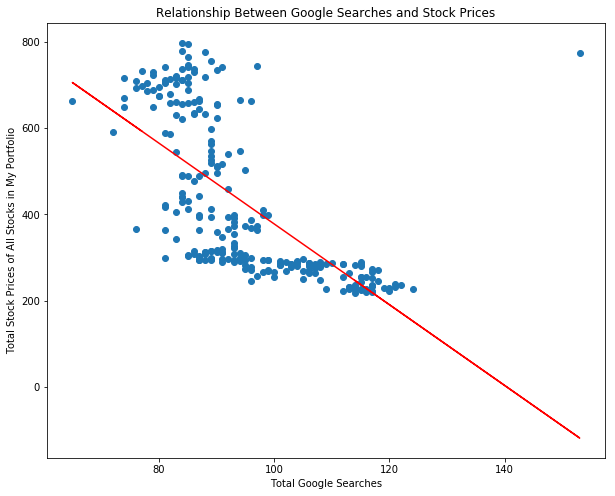

In [49]:
X1 = top_prices_weekly['Searches']
Y1 = top_prices_weekly['Total']
plt.xlabel('Total Google Searches')
plt.ylabel('Total Stock Prices of All Stocks in My Portfolio')
plt.title('Relationship Between Google Searches and Stock Prices')
plt.scatter(X1,Y1);

#Draw the trend line
z = np.polyfit(X1,Y1,1)
p = np.poly1d(z)
plt.plot(X1,p(X1),"r")
plt.show();

In [50]:
#Apply statsmodel to run regression and conclude detailed stats
x_hat = sm.add_constant(X1)
reg = sm.OLS(Y1, x_hat).fit()

In [51]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.438
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     200.6
Date:                Tue, 23 Apr 2019   Prob (F-statistic):           4.78e-34
Time:                        21:00:57   Log-Likelihood:                -1640.8
No. Observations:                 259   AIC:                             3286.
Df Residuals:                     257   BIC:                             3293.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1315.0483     63.536     20.698      0.000    1189.932    1440.165
Searches      -9.3732      0.662    -14.163      0.000     -10.676      -8.070
==============================================================================
Omnibus:                       90.382   Durbin-Watson:                   0.240
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              440.616
Skew:                           1.328   Prob(JB):                     2.10e-96
Kurtosis:                       8.811   Cond. No.                         717.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
# Append My Portfolio statistics to the original dataframe 'df'
df.loc['My Portfolio'] = ['Minimum Variance Portfolio','Technology and Engineering',top_returns['Total'].mean()*250,top_returns['Total'].std()*250**0.5,'Unkown','Unkown','Unkown',top_returns['Total'].min(),top_returns['Total'].max()]

### Pick stocks with over 20% returns over past 10 years and compare with my minimum variance portfolio

In [53]:
df = df.sort_values('Realized_Return',ascending = False)

trace0 = go.Bar(
    x = df[df['Realized_Return']>0.2].index,
    y = df['Realized_Return'],
    name = 'Realized Return',
    text = df['Company'],
    marker = dict(
        color='rgb(49,130,189)',
    )
)

trace1 = go.Bar(
    x = df[df['Realized_Return']>0.2].index,
    y = df['Volatility'],
    name = 'Volatility',
    text = df['Company'],
    marker = dict(
        color='rgb(204,204,204)',
    )
)



layout = go.Layout(
    title=go.layout.Title(
        text='Comparsion on Realized Returns vs. Volatilities with My Minimum Variance Portfolio ',
        xref='paper',
        x=0
    ),
    xaxis=go.layout.XAxis(
        tickangle=45,
        title=go.layout.xaxis.Title(
            text='Company Tickers',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    yaxis=go.layout.YAxis(
        tickformat = '%',
        title=go.layout.yaxis.Title(
            text='Stock Returns',
            font=dict(
                family='Courier New, monospace',
                size=18,
                color='#7f7f7f'
            )
        )
    ),
    # Plot the red line of the average S&P 500 return
    shapes=[
            {
                'type': 'line',
                'xref': 'paper',
                'x0': 0,
                'y0': 0.0797, # use absolute value or variable here
                'x1': 1,
                'y1': 0.0797, # ditto
                'line': {
                    'color': 'red',
                    'width': 1,
                    'dash': 'solid',
                },
            },
        ],
    
)

data = [trace0,trace1]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

## Section VI: Conclusion & Lessons Learned 

1. From the regression against the S&P 500, less than 70% of the portfolio returns are explained by the S&P 500 returns. The minimum variance portfolio performance is generally aligned with the market but can not be predicted by the market performance. If you pick the stocks in your portfolio wisely and allocate the capital base on the efficient frontier, you should be able to overperform the market.


2. Looking at the visualizations about the comparison between realized returns and expected returns, there is much firm-specific risk aside of the market. Unsystematic risk can be diversified by investing in a portfolio of multiple stocks rather than investing in individual stocks and betting on its growth. Comparing the average return of the minimum variance portfolio with the 30 stocks performance, it not only outperformed the market but achieved the lowest volatility when earning more than 20% returns. Moreover, the minimum variance portfolio has overperformed the market by a factor of 1.5.


3. By regression against relevant keywords such as "Boeing", "Software", and "Healthcare", I am able to analyze the relationship between Google searches and total stock prices of the minimum variance portfolio. Although the adjusted R squared is around 40%, which means the correlation is not high, I could conclude in some cases when people are frequently searching industry or company related keywords on Google, it signals the potential negative returns or downward trends of the stock prices of your portfolio. In this case, 40% of stock prices of the minimum variance portfolio can be explained by the Google searches.


### Have questions? Interested to learn more?
Contact me at: conghao@iu.edu